In [33]:
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
import numpy as np
import pandas as pd
import time
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation 
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import string
from string import digits
import nltk
from collections import Counter
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()
import math
from collections import defaultdict
#from yellowbrick.cluster import KElbowVisualizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
url = "https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag="
df=pd.DataFrame(columns=['price','locali','superficie','bagni','piano'])

In [23]:
pg=1
i=1
while i <= 10000:

    time.sleep(1)
    response = requests.get(url+str(pg))
    html_soup = bs(response.text, 'html.parser')
    item_containers = html_soup.find_all('div', class_ = 'listing-item_body--content')
    for item in item_containers:
        listing = []
        listing.append(item.a['href'])
            
        for feature in item.ul.find_all('li', class_ = 'lif__item'):
            try:
                if 'lif__pricing' in feature['class']:
                    listing.append(feature.text.strip().split(' ')[1])
                    next
                else:
                    if feature.find('div', class_='lif__text').text == 'locali':
                        listing.append(feature.span.text)
                    if feature.find('div', class_='lif__text').text == 'superficie':
                        listing.append(feature.span.text)
                    if feature.find('div', class_='lif__text').text == 'bagni':
                        listing.append(feature.span.text)
                    if feature.find('div', class_='lif__text').text == 'piano':
                        listing.append(feature.abbr.text.strip())
            except:
                next
        if len(listing) == 6:
            df=df.append(pd.Series(listing, index=['url','price','locali','superficie','bagni','piano']),ignore_index=True)
            i +=1
    pg+=1


In [28]:
json=df.to_json('announcements.json',orient='index')

In [2]:
test=pd.read_json('announcements.json',orient='index')

## Clustering
We implemented clustering for the first matrix: first we stripped datas in order to clean records from characters and symbols, then we converted data into float

In [3]:
#Creating a subset for the clustering
clusDF=test[['bagni','locali','price','superficie']]

#stripping data for bagni
clusDF['bagni']=clusDF['bagni'].map(lambda x: x.strip())
clusDF['bagni']=clusDF['bagni'].map(lambda x: x.strip("+"))

#stripping data  for locali
clusDF['locali']=clusDF['locali'].map(lambda x: x.strip())
clusDF['locali']=clusDF['locali'].map(lambda x: x.strip("+"))

#stripping data for price
clusDF['price']=clusDF['price'].str.replace(".","")
clusDF['price']=clusDF['price'].str.replace("€","")

#convert into float
for col in ['bagni','locali','price']:
    clusDF[col] = clusDF[col].astype('float')

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

We plotted correlation via heatmap and distortion by number of cluster in order to find the "elbow" and the right k value for the KMeans algorithm

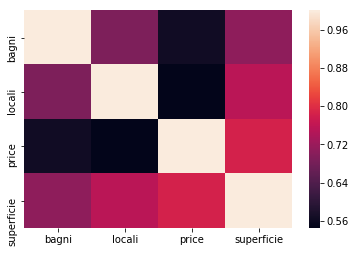

In [4]:
#corr heatplot
cor=clusDF.corr()
sns.heatmap(cor)

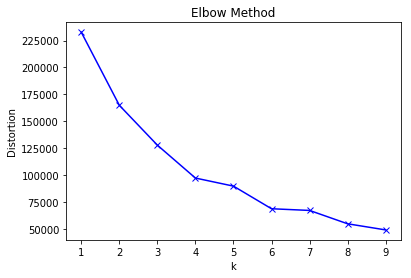

In [5]:
#plotting the elbow in order to choose k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(clusDF)
    kmeanModel.fit(clusDF)
    distortions.append(sum(np.min(cdist(clusDF, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / clusDF.shape[0])
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

Through the elbow method we set the k to 4, then we implemented KMeans and created a new variable that assign to every record the cluster from which it belogs to

In [6]:
#clustering with k=4 
clmns = ['bagni','locali','price','superficie']
kmeans=KMeans(n_clusters=4).fit(clusDF)
labels = kmeans.labels_
#adding a column which display at what cluster any record belongs
clusDF['clusters'] = labels
centers = kmeans.cluster_centers_

clmns.extend(['clusters'])

print(clusDF[clmns].groupby(['clusters']).mean())

             bagni    locali         price  superficie
clusters                                              
0         1.333957  2.855703  2.374529e+05   83.377304
1         2.621072  4.770795  1.339073e+06  221.846211
2         2.032271  4.161356  5.967959e+05  142.635666
3         2.840580  4.985507  3.137681e+06  349.130435


C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(30.7586,0.5,'Prices')

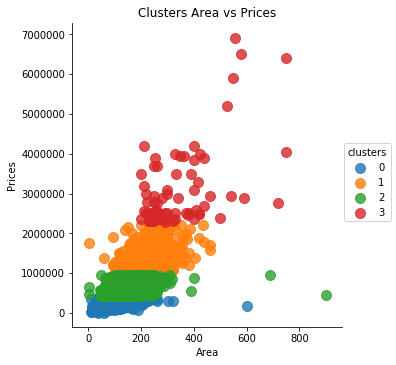

In [7]:
#scatterplot with superficie and price and the 4 clusters
sns.lmplot('superficie', 'price', 
           data=clusDF, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "F", 
                       "s": 100})
plt.title('Clusters Area vs Prices')
plt.xlabel('Area')
plt.ylabel('Prices')

Dendrogram confirms that 4 is the better number of cluster, at a distance of 1.5

In [8]:
Z = linkage(clusDF, 'ward')

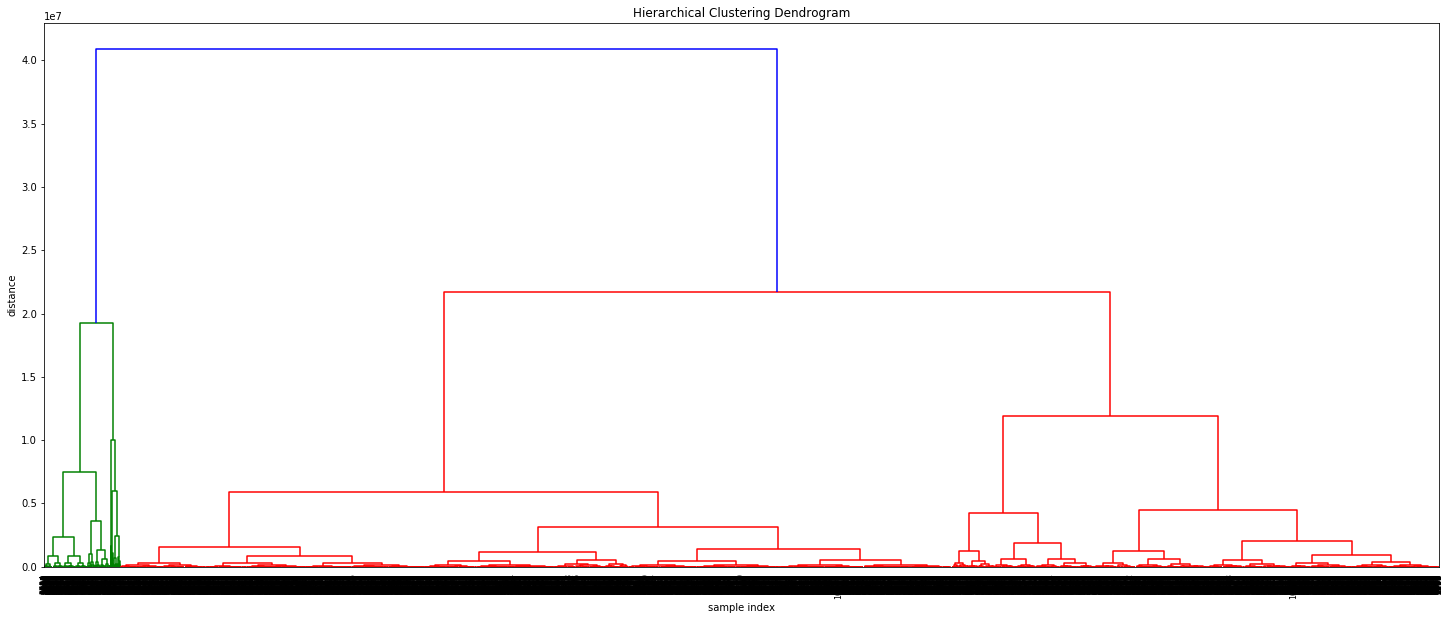

In [9]:
#plotting dendrogram

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

### Second matrix of tfidf values

now we work with description matrix: we took a sample of the whole matrix because its size makes our computer crash so we need to work on a smaller sample

In [10]:
mtrx2=pd.read_json('matrix 2.json',orient='index')
mtrx2=mtrx2.transpose()

,0
0,papillo eur PAPILLO EUR in elegante complesso ...
1,Appartamento nuova costruzione P.zza San Giova...
2,Appartamento nuova costruzione P.zza San Giova...
3,Appartamento nuova costruzione P.zza San Giova...
4,Appartamento nuova costruzione P.zza San Giova...
5,Appartamento nuova costruzione P.zza San Giova...
6,Appartamento nuova costruzione P.zza San Giova...
7,Migliora la qualità della tua vita in una casa...
8,Appartamento nuova costruzione P.zza San Giova...
9,Appartamento nuova costruzione Piazza San Giov...


In [11]:
#taking a sample JUST BECAUSE DATA IS TOO BIG
samp=mtrx2.sample(1000)
samp=samp.reset_index()
samp=samp.drop(columns=['index'])
mtrx2=samp

We created a function to clean description, stemming all words and deleting punctuation;
then we created a vocabulary list that contains all words that appears in all documents description

In [13]:
def text_clean(des):
    
    des=des.strip()
    des=des.replace("\\n", " ").replace("/", " ").replace("-", " ").replace("’",' ')
    
    # Punctuation
    custom_punctuation = string.punctuation
    custom_punctuation = custom_punctuation + '“' + '–'
    for char in custom_punctuation:
        des = des.replace(char, ' ')
        
    # Split into list.
    des = des.lower()
    des = des.split(" ")

    # Remove stop words.
    des = [word for word in des if not word in set(stopwords.words('italian'))]

    # Perform the stemming process.
    des = [ps.stem(word) for word in des]

    # Rejoin line text  
    des = " ".join(des)
    
    #remove digits 
    des=''.join(i for i in des if not i.isdigit())
    des=des.replace('  ',' ')
    
    return des

In [14]:
vocabulary=[]
for txt in range(len(mtrx2)):
    clean_txt=text_clean(mtrx2[0][txt])
    clean_txt=clean_txt.split(' ')
    for word in clean_txt:
        vocabulary.append(word)

In [15]:
vocabulary = list(set(vocabulary))

vocabulary = vocabulary[1:]

vocabulary

['qualita',
 'equidistant',
 'present',
 'professionale',
 'competentispes',
 'aspett',
 'meraviglios',
 'romaaventino',
 'realizzabil',
 'tempo',
 'intorno',
 'coniugato',
 'coloro',
 'classico',
 'rifatto',
 'tradizional',
 'rinunciar',
 'necessario',
 'spaziando',
 'venezia',
 'altro…',
 'ernesto',
 'strisc',
 'palesando',
 'versat',
 'bassissimi',
 'condominio',
 'fax',
 'lauranaproponiamo',
 'termici',
 'dal',
 'fortement',
 'mai',
 'inserti',
 'progeacasa',
 'copropriété',
 'aspirapolver',
 'vintag',
 'frassini',
 'passeggiata',
 'duilio',
 'volessero',
 'dei\xa0',
 'ariosità',
 'simonetta',
 'statuario',
 'portar',
 'forniti',
 'totalità',
 'pietro',
 'vii',
 'ect',
 'ritenuti',
 'orsi',
 'non”',
 'completi',
 'avec',
 'scimonelli',
 'guardaroba',
 'luxurybrick',
 'baracch',
 'configurar',
 'ridosso',
 'prim',
 'rialzato',
 'linari',
 'soddisfarlo',
 'gradoni',
 'serena',
 'casalein',
 'hold',
 'mqanno€',
 'contrario',
 'raffinata',
 'tavol',
 'catulo',
 'sanzioni',
 'amatori',


In order to get tfidf index we created two dictionaries: 
-Dict maps all words and documents from which they belongs;
-inv_Dict is the inverted index dictionary, that associates every document to the index of words that are in that document.

Then we calculated tfidf score and created a matrix in wich columns are the words from vocabulary, and rows are the documents we are studying

In [16]:
Dict = {}
Inv_Dict = {}
for des in range(len(mtrx2)):
    clean_des=text_clean(mtrx2[0][des])
    clean_des=clean_des.split(' ')
    for i in set(clean_des):
        if i not in Dict:
            Inv_Dict[len(Dict)]=[str(des)]
            Dict[i]=len(Dict)        
        else:
            Inv_Dict[Dict.get(i)].append(str(des))

In [17]:
n = len(mtrx2)
tfidf_word_dict = {}
for des in range(len(mtrx2)):
    clean_des=text_clean(mtrx2[0][des])
    clean_des=clean_des.split(' ')
    counter = Counter(clean_des)
    for word in vocabulary:
        tf = counter[word]/len(clean_des)
        Nj=len(Inv_Dict[(Dict[word])])
        Idfj=math.log10(n/Nj)
        
        tfidf = tf*Idfj
        if des not in tfidf_word_dict.keys():
            tfidf_word_dict[des] = [tfidf]
        else:
            tfidf_word_dict[des].append(tfidf)

In [18]:
tfidfMTRX = pd.DataFrame(list(tfidf_word_dict.values()), columns = [word for word in vocabulary])
tfidfMTRX.index.name = 'Announcement'

We repeated cluster analysis as did before for the first matrix:

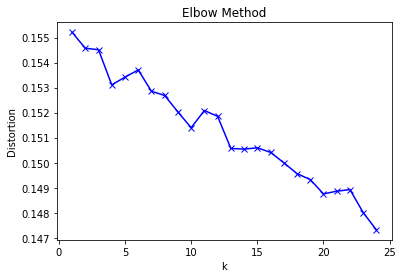

In [19]:
#plotting the elbow in order to choose k
distortion = []
K = range(1,25)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(tfidfMTRX)
    kmeanModel.fit(tfidfMTRX)
    distortion.append(sum(np.min(cdist(tfidfMTRX, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / tfidfMTRX.shape[0])
plt.plot(K, distortion, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

In [26]:
#clustering with k=5 
clmns2 = tfidfMTRX.columns.values
kmeans2=KMeans(n_clusters=5).fit(tfidfMTRX)
labels2= kmeans2.labels_
#adding a column which display at what cluster any record belongs
tfidfMTRX['clusters'] = labels2
centers = kmeans2.cluster_centers_

clmns2=list(clmns2)
clmns2.extend(['clusters'])

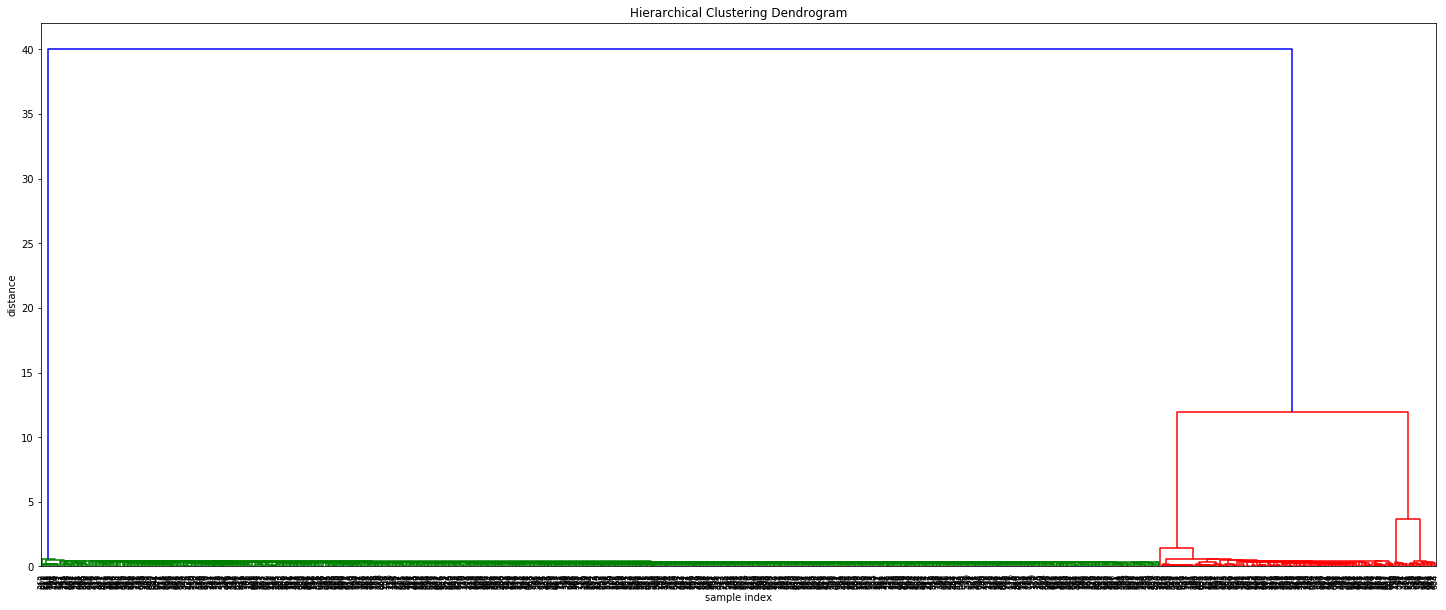

In [27]:
Z = linkage(tfidfMTRX, 'ward')

#plotting dendrogram

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

Finally we defined jaccard similarity fuction, as the size of intersection of two sets divided by the size of the union.

Jaccard similarity is computed on the two lists (one for each matrix) that associate every record to the cluster from wich it belongs to.

In [28]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    print(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection / union)

In [29]:
clus1=clusDF['clusters']
clus2=tfidfMTRX['clusters']

In [37]:
information_dict=defaultdict(list)
for i in clusDF.index:
    information_dict[labels[i]].append(i)


description_dict=defaultdict(list)
for i in tfidfMTRX.index:
    description_dict[tfidfMTRX['clusters'][i]].append(i)


jaccard_sim_dict={}
for info_cluster_id in information_dict.keys():
    for desc_cluster_id in description_dict.keys():
        jaccard_sim_dict[(info_cluster_id,desc_cluster_id)]=\
        jaccard_similarity(information_dict[info_cluster_id],description_dict[desc_cluster_id])

[0, 4, 5, 6, 7, 8, 9, 11, 14, 15, 20, 21, 22, 26, 28, 30, 31, 32, 34, 35, 37, 39, 43, 48, 54, 55, 57, 58, 59, 61, 62, 63, 64, 66, 72, 75, 78, 79, 80, 81, 83, 84, 85, 90, 92, 94, 98, 100, 102, 104, 105, 106, 107, 109, 111, 114, 115, 117, 119, 120, 121, 123, 125, 126, 129, 130, 133, 136, 137, 139, 140, 141, 143, 144, 148, 149, 151, 152, 157, 158, 159, 161, 162, 163, 164, 166, 167, 170, 173, 174, 175, 176, 179, 181, 183, 184, 186, 188, 189, 191, 192, 194, 195, 199, 202, 203, 204, 206, 208, 210, 211, 213, 214, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226, 228, 229, 232, 233, 234, 236, 237, 239, 242, 244, 245, 246, 247, 248, 249, 250, 251, 253, 256, 257, 259, 260, 262, 264, 265, 269, 270, 272, 273, 274, 279, 281, 284, 285, 287, 288, 289, 290, 293, 294, 296, 297, 299, 300, 301, 302, 303, 305, 307, 308, 309, 312, 313, 314, 316, 317, 318, 319, 320, 324, 325, 326, 328, 332, 333, 334, 335, 336, 337, 339, 340, 341, 342, 346, 347, 349, 353, 355, 362, 363, 364, 365, 366, 368, 369, 372, 373, 376

In [38]:
import collections
jaccard_sim_sorted=collections.Counter(jaccard_sim_dict)
top_3_jaccard_sim=jaccard_sim_sorted.most_common(3)
top_3_jaccard_sim

[((2, 4), 0.0779436152570481),
 ((0, 4), 0.07166574432761483),
 ((1, 4), 0.036265432098765434)]

We can now say that the three most similiar clusters are  

2 and 4, 

0 and 4,

1 and 4.